In [1]:
import tensorflow as tf

from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.platform import gfile

import tensorflow_model_optimization as tfmot

import functools

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, pickle
import shutil
import json
from scipy.io import  wavfile
from IPython import display

import str_ww_util as util
import get_dataset
import keras_model as models

from IPython import display

In [2]:
rng = np.random.default_rng(2024)

In [3]:
from get_dataset import decode_audio, get_label, get_waveform_and_label, \
                        convert_labels_str2int, convert_to_int16, cast_and_pad, \
                        convert_dataset, get_preprocess_audio_func, prepare_background_data, \
                        get_training_data, count_labels, is_batched

In [4]:
Flags, unparsed = util.parse_command()

In [5]:
## Set these for an extra short test just to validate that the code runs
Flags.num_train_samples = 100
Flags.num_val_samples = 100
Flags.num_test_samples = 100

load_pretrained_model = True # True to load from a file, False to build/train from scratch
save_model = False

# 'trained_models/str_ww_model.h5' is the default save path for train.py
pretrained_model_path = 'trained_models/str_ww_model.h5' # path to load from if load_pretrained_model is True

Flags.epochs = 2

In [6]:
Flags.background_volume=1.0 # experimenting
Flags.use_qat = True

In [7]:
try:
    with open('streaming_config.json', 'r') as fpi:
        streaming_config = json.load(fpi)
    Flags.data_dir = streaming_config['speech_commands_path']
except:
    raise RuntimeError("""
        In this directory, copy streaming_config_template.json to streaming_config.json
        and edit it to point to the directories where you have the speech commands dataset
        and (optionally) the MUSAN noise data set.
        """)
Flags.bg_path = Flags.data_dir

In [8]:
# ds_train, ds_test, ds_val = get_training_data(Flags)

label_count=3
background_frequency = Flags.background_frequency
background_volume_range_= Flags.background_volume
model_settings = models.prepare_model_settings(label_count, Flags)

In [9]:
import importlib
importlib.reload(get_dataset)

<module 'get_dataset' from '/Users/jeremy/dev/tiny_mlperf/tiny_main/benchmark/training/streaming_wakeword/get_dataset.py'>

In [10]:
ds_train, ds_test, ds_val = get_dataset.get_training_data(Flags)


2024-02-12 21:49:56.537732: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-12 21:49:56.537752: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-12 21:49:56.537759: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-12 21:49:56.537786: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-12 21:49:56.537804: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


wav_decoder shape = (None,)
sliced_foreground shape = (16000,)
sliced_foreground shape = (1, 16000)
paddings shape[] = (2, 2)
wav_decoder shape = (None,)
sliced_foreground shape = (16000,)
sliced_foreground shape = (1, 16000)
paddings shape[] = (2, 2)
wav_decoder shape = (None,)
sliced_foreground shape = (16000,)
sliced_foreground shape = (1, 16000)
paddings shape[] = (2, 2)


In [11]:
for dat in ds_train.unbatch().take(1):
  print("One element from the training set has shape:")
  print(f"Input tensor shape: {dat[0].shape}")
  print(f"Label shape: {dat[1].shape}")
  print(f"Label : {dat[1]}")
  break


One element from the training set has shape:
Input tensor shape: (49, 1, 40)
Label shape: (3,)
Label : [0. 0. 1.]


In [12]:
## probably don't need to shuffle val and test sets
train_shuffle_buffer_size = 85511
ds_train = ds_train.shuffle(train_shuffle_buffer_size)

In [13]:
Flags.feature_type = 'td_samples'
ds_train_wav, ds_test_wav, ds_val_wav = get_training_data(Flags)
test_wav, test_label = next(ds_test_wav.unbatch().as_numpy_iterator())
test_wav = test_wav.squeeze()
test_wav = test_wav/np.max(np.abs(test_wav))

wav_decoder shape = (None,)
sliced_foreground shape = (16000,)
wav_decoder shape = (None,)
sliced_foreground shape = (16000,)
wav_decoder shape = (None,)
sliced_foreground shape = (16000,)


In [14]:

print(f"Test wav shape = {test_wav.shape}, min/max = {np.min(test_wav):5.3f}/{np.min(test_wav):5.3f}")

Test wav shape = (16000,), min/max = -1.000/-1.000


In [15]:
## Modify some settings so we only process one frame at a time
model_settings_online = model_settings.copy()
model_settings_online['desired_samples']    = model_settings_online['window_size_samples']
model_settings_online['spectrogram_length'] = 1
model_settings_online['fingerprint_size'] = model_settings_online['dct_coefficient_count']


In [16]:
feature_extractor_1frame = get_preprocess_audio_func(model_settings_online, is_training=False)
feature_extractor_full = get_preprocess_audio_func(model_settings, is_training=False)


In [17]:
x_feats_perf = feature_extractor_full({'audio':test_wav})['audio'].numpy()
print(x_feats_perf.shape)

wav_decoder shape = (16000,)
sliced_foreground shape = (16000,)
sliced_foreground shape = (1, 16000)
paddings shape[] = (2, 2)
(49, 1, 40)


In [18]:
## Do we get the same features by extracting one frame at a time, or
## is there any frame-to-frame adaptation
spec_one_shot = feature_extractor_full({'audio':test_wav})['audio'].numpy()
spec_per_frame = np.nan*np.zeros(spec_one_shot.shape)


for i in range(model_settings['spectrogram_length']):
  start = i*model_settings['window_stride_samples']
  stop = start + model_settings['window_size_samples']
  wav_clip = test_wav[start:stop]
  one_mel_spectrum = feature_extractor_1frame({'audio':wav_clip})['audio'].numpy()
  spec_per_frame[i,0,:] = one_mel_spectrum
  

wav_decoder shape = (16000,)
sliced_foreground shape = (16000,)
sliced_foreground shape = (1, 16000)
paddings shape[] = (2, 2)
wav_decoder shape = (480,)
sliced_foreground shape = (480,)
sliced_foreground shape = (1, 480)
paddings shape[] = (2, 2)
wav_decoder shape = (480,)
sliced_foreground shape = (480,)
sliced_foreground shape = (1, 480)
paddings shape[] = (2, 2)
wav_decoder shape = (480,)
sliced_foreground shape = (480,)
sliced_foreground shape = (1, 480)
paddings shape[] = (2, 2)
wav_decoder shape = (480,)
sliced_foreground shape = (480,)
sliced_foreground shape = (1, 480)
paddings shape[] = (2, 2)
wav_decoder shape = (480,)
sliced_foreground shape = (480,)
sliced_foreground shape = (1, 480)
paddings shape[] = (2, 2)
wav_decoder shape = (480,)
sliced_foreground shape = (480,)
sliced_foreground shape = (1, 480)
paddings shape[] = (2, 2)
wav_decoder shape = (480,)
sliced_foreground shape = (480,)
sliced_foreground shape = (1, 480)
paddings shape[] = (2, 2)
wav_decoder shape = (480,)

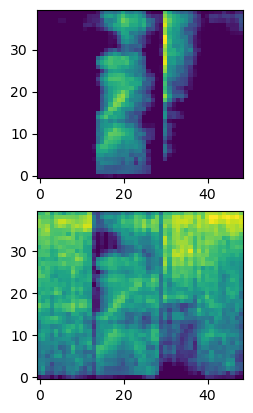

In [19]:
plt.subplot(2,1,1)
plt.imshow(spec_one_shot.squeeze().T, origin='lower')
plt.subplot(2,1,2)
plt.imshow(spec_per_frame.squeeze().T, origin='lower')


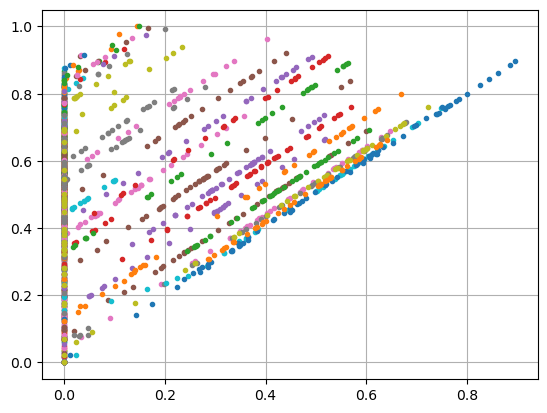

In [20]:
plt.plot(spec_one_shot.squeeze().T[:,:], spec_per_frame.squeeze().T[:,:], '.')

plt.grid(True)

## Convert the Feature Extractor into a Model


In [21]:
wav_clip.shape

(480,)

In [22]:
import importlib
importlib.reload(get_dataset)
# import get_dataset

<module 'get_dataset' from '/Users/jeremy/dev/tiny_mlperf/tiny_main/benchmark/training/streaming_wakeword/get_dataset.py'>

In [23]:
wav_in = tf.keras.layers.Input(shape=(480,), batch_size=1)
streaming_feature_exctractor = get_dataset.get_preprocess_audio_func(model_settings_online, 
                                                                     is_training=False,
                                                                     wave_frame_input=True)
features = streaming_feature_exctractor(wav_in)

feature_model = tf.keras.models.Model(inputs=wav_in, outputs=features)

wav_decoder shape = (1, 480)
sliced_foreground shape = (1, 480)
sliced_foreground shape = (1, 480)
paddings shape[] = (2, 2)


## Scratch Space


In [24]:
feature_extractor

NameError: name 'feature_extractor' is not defined

In [ ]:
def get_ufe_spectrum(wav_in):
    i16max = 2**15-1
    i16min = -2**15
    preemphasis_coef = 1 - 2 ** -5
    
    ufe_args = {
        'sample_rate':16000,
        'window_size':window_size_ms,
        'window_step':window_stride_ms,
        'num_channels':40,
        'upper_band_limit':7999.9,
        'lower_band_limit':0.0,
        'smoothing_bits':10,
        'even_smoothing':0.0, # 0.025,
        'odd_smoothing':0.0, # 0.025,
        'min_signal_remaining':0.00,
        'enable_pcan':False,
        'pcan_strength':0.0,
        'pcan_offset':80.0,
        'gain_bits':21,
        'enable_log':True,
        'scale_shift':6,
        'left_context':0,
        'right_context':0,
        'frame_stride':1,
        'zero_padding':False,
        'out_scale':1,
        'out_type':tf.uint16
    }
    # tf.constant(1-2**-5, dtype='int16')
    wav_in = wav_in[1:] - preemphasis_coef * wav_in[:-1]
    zero_padding = tf.zeros(16000 - len(wav_in), dtype=tf.int16)
    wav_in = tf.cast(0.5*wav_in*(i16max-i16min), tf.int16)  # scale float [-1,+1]=>INT16
    equal_length = tf.concat([wav_in, zero_padding], 0)
    
    ## Make sure these labels correspond to those used in micro_features_micro_features_generator.cpp
    spectrogram = frontend_op.audio_microfrontend(equal_length, **ufe_args)
                                                  # sample_rate=16000, 
                                                  # num_channels=40, window_size=window_size_ms, 
                                                  # window_step=window_stride_ms)
    return spectrogram